In [1]:
import numpy as np
import pandas as pd
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt

def evaluate_action_network(rat_env, action_network, n_episodes):
    
    action_network.eval()

    reward_buffer = []
    action_buffer = []
    for i in range(n_episodes):
        rat_env.reset()
        for t in range(0,100): #10 steps in each env (user moving)
            current_state, _, _ = rat_env.get_state()
            state = expand_list(current_state,rat_env.n_users)
            action_list = action_network.forward(input=state)
            action_list = torch.hstack([torch.abs(action_list[:, 0]).view(-1,1), action_list[:, 1].view(-1,1), torch.abs(action_list[:, 2]).view(-1,1), action_list[:, 3:]])
            
            a = action_list[:,4].detach()
            real_val = (a+1) * rat_env.n_stations/2
            a=real_val
            _, actions , _, reward = rat_env.step(a.detach())
            
            action_buffer.append(actions)
            reward_buffer.append(reward)
    
    return reward_buffer,action_buffer



def plot_reward(reward_buffer):
    n_runs = len(reward_buffer)
    n_agents = len(reward_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_rewards = np.array([reward_buffer[run][i] for run in range(n_runs)])
        
        ax.plot(range(n_runs), agent_rewards, label=f"Agent {i+1}")

        ax.set_title(f"Agent {i+1}")
        ax.set_xlabel("Run")
        ax.set_ylabel("Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Reward Evolution for Each Agent Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_actions(actions_buffer):
    n_runs = len(actions_buffer)
    n_agents = len(actions_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_actions = np.array([int(torch.round(actions_buffer[run][i])) for run in range(n_runs)])
        ax.plot(range(n_runs), agent_actions, label=f"Agent {i+1}")

        ax.set_title(f"Agent {i+1}")
        ax.set_xlabel("Run")
        ax.set_ylabel("Station chosen")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Stations Chosen by Each Agent Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_qjr8j34 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Initialize enviroment

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


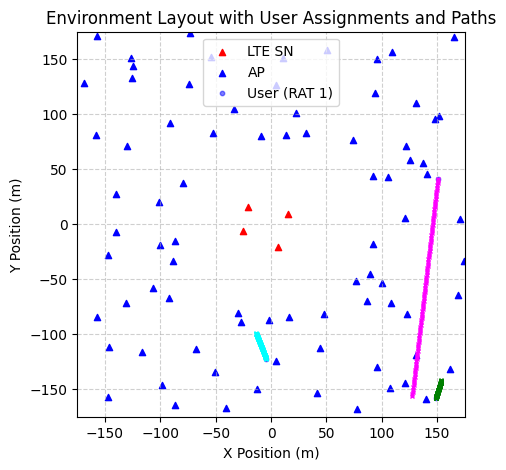

In [2]:
# Parameters for the Multi-RAT Network
user_area_width = 100
ltesn_area_width = 50
n_aps = 81
n_users = 3
n_steps = 100
cqi_dataset = pd.read_csv("cqi_distance.csv")
rssi_dataset = pd.read_csv("rssi_distance.csv")

rat_env = Multi_RAT_Network(user_area_width, ltesn_area_width, n_users, n_aps, cqi_dataset, rssi_dataset, n_steps, plot=True)

In [3]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim=5, lat_dims=128, layers=4)
action_network.load_state_dict(torch.load(r"/var/tmp/alvaro/Nash_DQN_RAT/Action_Net_999.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes = 15)

IndexError: list index out of range

In [ ]:
plot_reward(rewards)

In [ ]:
plot_actions(actions)